In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, RNN, LSTM, Flatten, SpatialDropout1D, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import warnings
warnings.simplefilter(action='ignore')

Using TensorFlow backend.


In [2]:
# data loading
path = "~/conala-corpus/"
test_path = "conala-test.json"
train_path = "conala-train.json"
mined_path = "conala-mined.jsonl"
test = pd.read_json(path+test_path)
train = pd.read_json(path+train_path)
mined = pd.read_json(path+mined_path, lines=True)
mined = mined.sample(39500)
# train test split
X = mined[['intent', 'snippet']]
y = mined['prob'].as_matrix()
del mined
del train

In [3]:
# data cleanup to save memory
# usually you would want to clean up special characters like "'" or ";" but since we are dealing with code here....
X['intent'] = X['intent'].apply(lambda x: x.lower())
X['intent'] = X['intent'].apply(lambda x: re.sub(pattern='[^a-z0-9]', string=x, repl=' '))

In [4]:
# concatenate snippet and intent
# the network is powerful enough and gets enough data
# to learn that our border word marks a border
X['intent'] = X['intent'] + '||BORDER||' + X['snippet']

In [5]:
X = X['intent']

In [6]:
# we tokenize the text and pad the tokens
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH  = 1000
EMBEDDING_DIM = 1000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [7]:
import pickle
# saving
with open('tokenizer.pk', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=1)

In [13]:
# this is a rather simple LSTM
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(35, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

epochs = 10
batch_size = 512

history = model.fit(X, y, epochs=epochs,verbose=1, batch_size=batch_size, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

KeyboardInterrupt: 

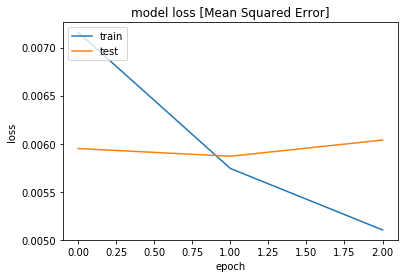

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss [Mean Squared Error]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_12k.pdf')
plt.show()

In [10]:
from keras.models import load_model
model.save('LSTM_12k.h5')
model.save_weights('model.h5')
model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()